In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

## Catfish sales data

In [2]:
catfish_sales = pd.read_csv(
    r"D:\Time series analysis\catfish.csv",
    parse_dates=[0],
    index_col=0,
    date_format='%Y-%m-%d'  # Use date_format instead of date_parser if applicable
)

In [3]:
#infer the frequency of the data
catfish_sales=catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

In [4]:
catfish_sales.squeeze()

Date
1986-01-01     9034
1986-02-01     9596
1986-03-01    10558
1986-04-01     9002
1986-05-01     9239
              ...  
2012-08-01    14442
2012-09-01    13422
2012-10-01    13795
2012-11-01    13352
2012-12-01    12716
Freq: MS, Name: Total, Length: 324, dtype: int64

In [5]:
start_date=pd.to_datetime('1996-1-01')
end_date=pd.to_datetime('2000-1-01')
lim_catfish_sales=catfish_sales[start_date:end_date]

# Introduce anamoly

In [6]:
# At december 1 1998

# Now you can safely modify the DataFrame
lim_catfish_sales.loc[datetime(1998, 12, 1)] = 1000

C:\Users\ASHU\AppData\Local\Temp\ipykernel_12084\1831678384.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lim_catfish_sales.loc[datetime(1998, 12, 1)] = 1000


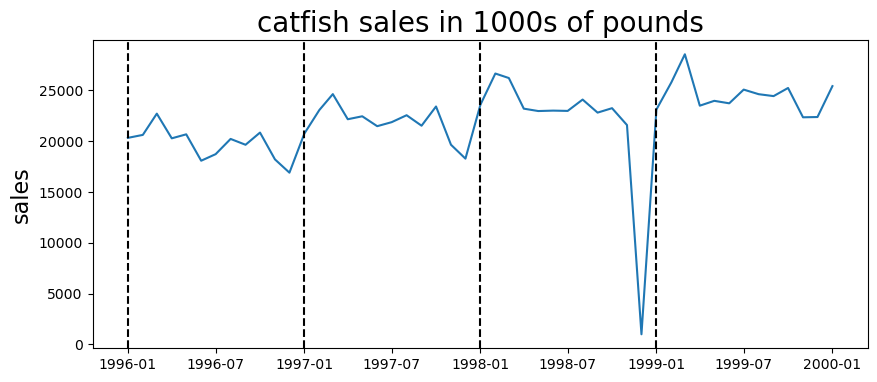

In [7]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('catfish sales in 1000s of pounds' , fontsize=20)
plt.ylabel('sales',fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--')

## Remove the trend

In [8]:
first_diff=lim_catfish_sales.diff()[1:]


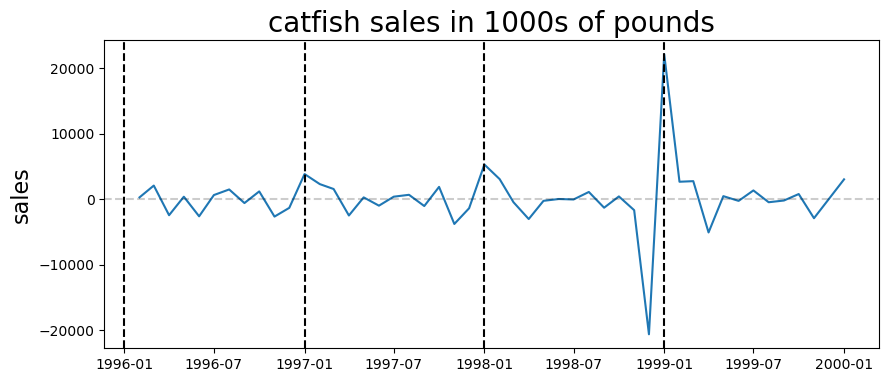

In [9]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('catfish sales in 1000s of pounds' , fontsize=20)
plt.ylabel('sales',fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--')
plt.axhline(0,color='k',linestyle='--',alpha=0.2)

## we have taken first diff so integrated model here we take is 1

## ACF

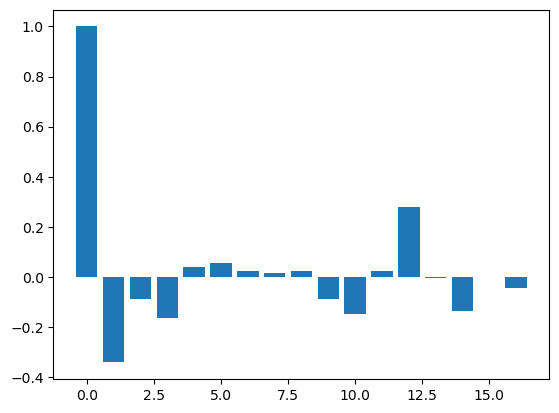

In [10]:
acf_vals = acf(first_diff)
num_lags = min(20, len(acf_vals))  # Adjust num_lags to be at most the length of acf_vals
plt.bar(range(num_lags), acf_vals[:num_lags])
plt.show()


# Based on ACF, we should start with a seasonal MA process

# PACF

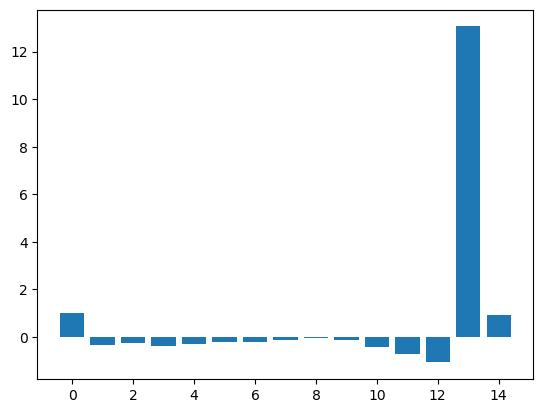

In [11]:
pacf_vals = pacf(first_diff)
num_lags = min(15, len(pacf_vals))  # Adjust num_lags to be at most the length of acf_vals
plt.bar(range(num_lags), pacf_vals[:num_lags])
plt.show()

# Based on pacf , we should satrt with a seosonal AR process
# Get training and testing sets¶

In [12]:
train_end=datetime(1999,7,1)#training data from 2010 to 2018 last
test_end=datetime(2000,1,1)#test data from 2019 satring to 2019 ending
train_data=lim_catfish_sales[:train_end]
test_data=lim_catfish_sales[train_end+timedelta(days=1):test_end]

# Fit the SARIMA model¶

In [13]:
my_order = (0,1,0) #non-seosonal part
my_seasonal_order = (1, 0, 1, 12) #seosonal part
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [14]:
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.09899234771728516


C:\Users\ASHU\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\ASHU\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [15]:
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Total   No. Observations:                   43
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -415.013
Date:                              Sun, 18 Aug 2024   AIC                            836.027
Time:                                      13:19:22   BIC                            841.240
Sample:                                  01-01-1996   HQIC                           837.938
                                       - 07-01-1999                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.2619      0.260     -1.008      0.314      -0.771       0.247
ma.S.L12       1.00

In [16]:
#get prediction and residuals
predictions=model_fit.forecast(len(test_data))
predictions=pd.Series(predictions,index=test_data.index)
residuals=test_data-predictions

In [17]:
print(test_data.head())

            Total
Date             
1999-08-01  24618
1999-09-01  24430
1999-10-01  25229
1999-11-01  22344
1999-12-01  22372


In [18]:
print(predictions.head())

Date
1999-08-01    25722.170725
1999-09-01    25305.087564
1999-10-01    25091.599231
1999-11-01    25047.432447
1999-12-01    14453.075443
Freq: MS, Name: predicted_mean, dtype: float64


In [19]:
print(residuals.head())

            Total  1999-08-01 00:00:00  1999-09-01 00:00:00  \
Date                                                          
1999-08-01    NaN                  NaN                  NaN   
1999-09-01    NaN                  NaN                  NaN   
1999-10-01    NaN                  NaN                  NaN   
1999-11-01    NaN                  NaN                  NaN   
1999-12-01    NaN                  NaN                  NaN   

            1999-10-01 00:00:00  1999-11-01 00:00:00  1999-12-01 00:00:00  \
Date                                                                        
1999-08-01                  NaN                  NaN                  NaN   
1999-09-01                  NaN                  NaN                  NaN   
1999-10-01                  NaN                  NaN                  NaN   
1999-11-01                  NaN                  NaN                  NaN   
1999-12-01                  NaN                  NaN                  NaN   

            2000-0

In [20]:
predictions = predictions.squeeze()  # Convert predictions to Series if it's not already
test_data = test_data.squeeze()      # Convert test_data to Series if it's not already

# Check the indices
print(test_data.index)
print(predictions.index)

DatetimeIndex(['1999-08-01', '1999-09-01', '1999-10-01', '1999-11-01',
               '1999-12-01', '2000-01-01'],
              dtype='datetime64[ns]', name='Date', freq='MS')
DatetimeIndex(['1999-08-01', '1999-09-01', '1999-10-01', '1999-11-01',
               '1999-12-01', '2000-01-01'],
              dtype='datetime64[ns]', name='Date', freq='MS')


In [21]:
residuals = test_data - predictions
print(residuals.head())

Date
1999-08-01   -1104.170725
1999-09-01    -875.087564
1999-10-01     137.400769
1999-11-01   -2703.432447
1999-12-01    7918.924557
Freq: MS, dtype: float64


Text(0, 0.5, 'Error')

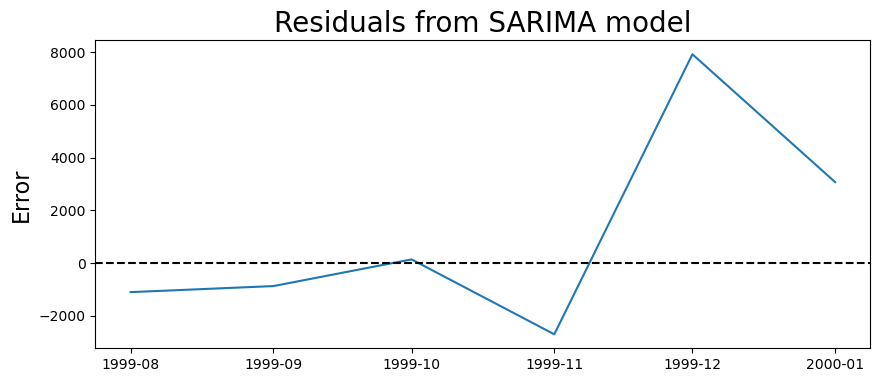

In [22]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0,linestyle='--',color='k')
plt.title("Residuals from SARIMA model", fontsize=20)
plt.ylabel('Error',fontsize=16)

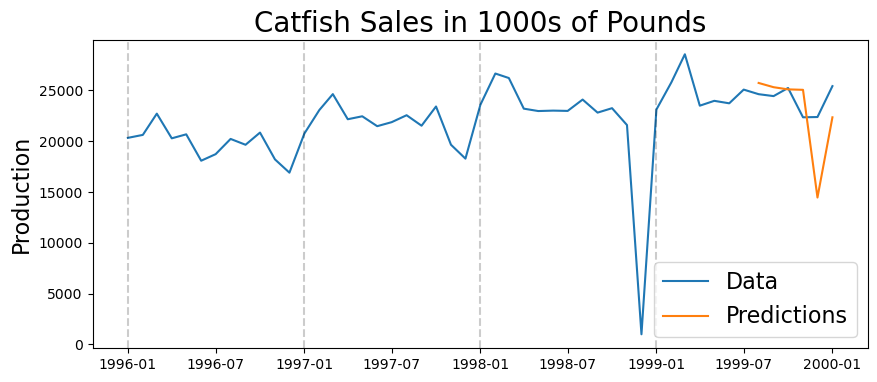

In [23]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [24]:
print('Mean absolute percent error:', round(np.mean(abs(residuals/test_data)),4))

Mean absolute percent error: 0.1136


In [25]:
print('Root mean sqaure Error', np.sqrt(np.mean(residuals**2)))

Root mean sqaure Error 3684.099218397738


# Rolling forecast origin¶

In [26]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = lim_catfish_sales[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

C:\Users\ASHU\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\ASHU\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\ASHU\AppData\Local\Temp\ipykernel_12084\3978322752.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[25722.17072516]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  rolling_predictions[train_end] = pred
C:\Users\ASHU\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

In [27]:
rolling_residuals=test_data-rolling_predictions

Text(0, 0.5, 'Error')

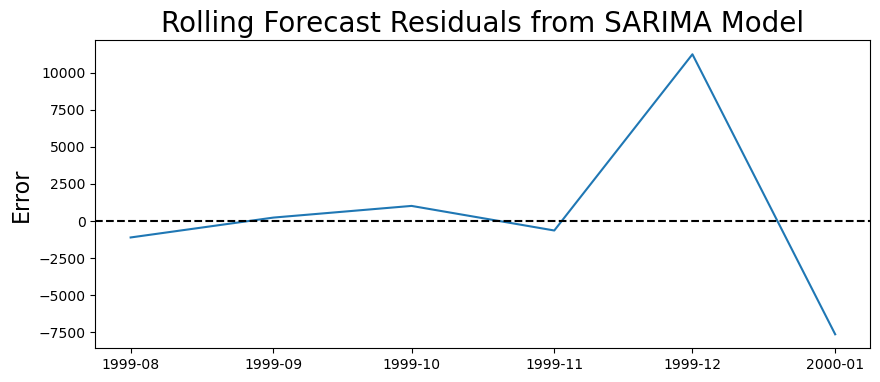

In [28]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

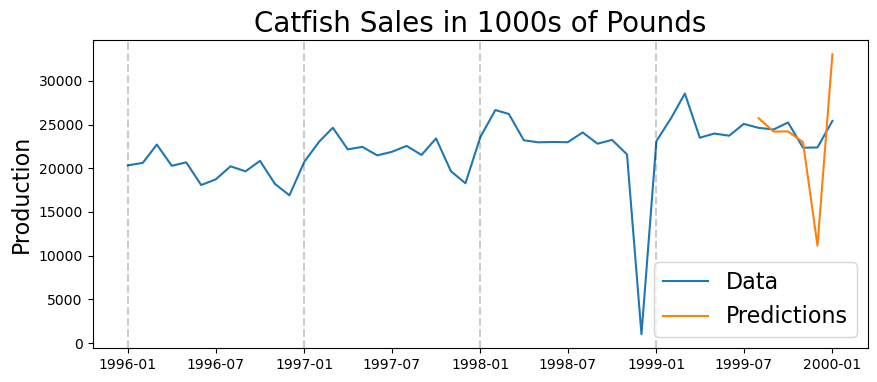

In [29]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [30]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))


Mean Absolute Percent Error: 0.1542


In [31]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))


Root Mean Squared Error: 5581.381546076358


## Detecting the Anamoly

# Attempt 1: Deviation Method

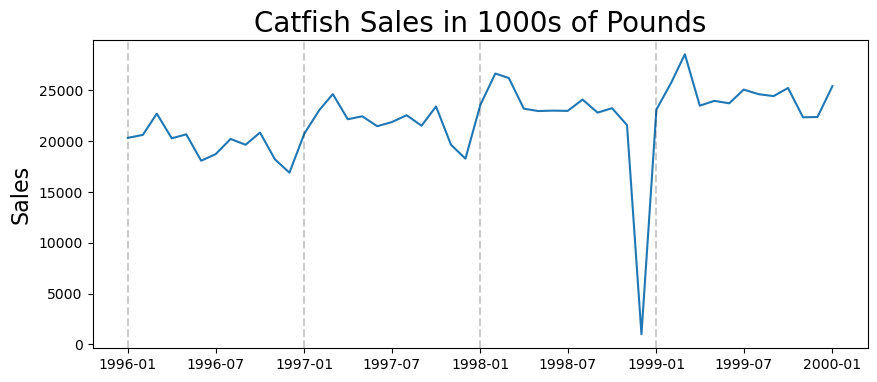

In [32]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [33]:
rolling_deviations = pd.Series(dtype=float, index = lim_catfish_sales.index)

In [34]:

    #get the deviation within this window
    rolling_deviations = lim_catfish_sales.expanding().std()

In [35]:
#get the difference in deviation between one time point and the next
diff_rolling_deviations = rolling_deviations.diff()

In [36]:
diff_rolling_deviations

,Total
Date,
1996-01-01,NaN
1996-02-01,NaN
1996-03-01,1093.647565
1996-04-01,-139.611236
1996-05-01,-145.877037
1996-06-01,458.946561
1996-07-01,21.246074
1996-08-01,-110.815080
1996-09-01,-76.077319


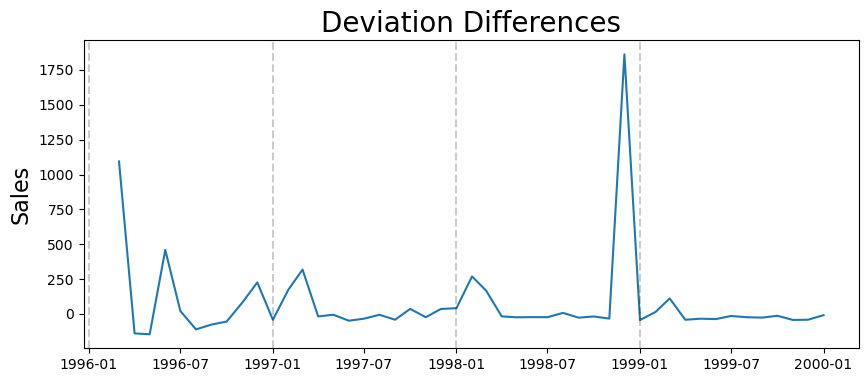

In [37]:
plt.figure(figsize=(10,4))
plt.plot(diff_rolling_deviations)
plt.title('Deviation Differences', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

# starting is high it doesn't mean that there is anamoly it means there is not too amny numbers.
# thats the drawback if anamoly occur on stating then detection will be not so easy.

## Attempt 2 : Seasonal Method

In [38]:
month_deviations = lim_catfish_sales.groupby(lambda d: d.month).std()

In [54]:
month_deviations

,Total
Date,
1,2105.840402
2,2741.500973
3,2473.136790
4,1452.396726
5,1379.643764
6,2510.305343
7,2648.906992
8,1973.452305
9,2025.372949


Text(0, 0.5, 'Sales')

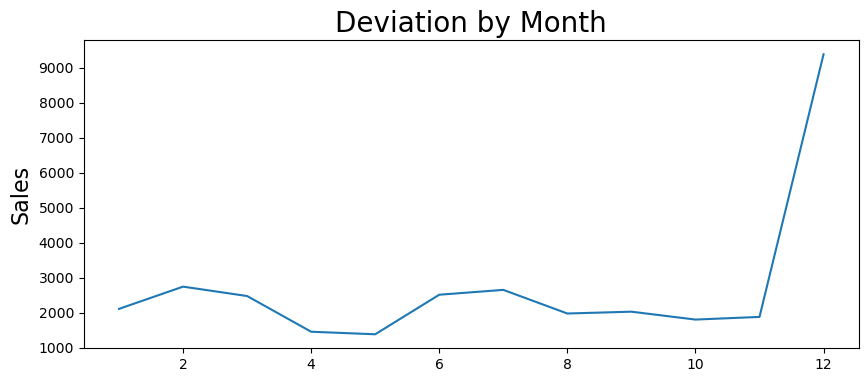

In [39]:
plt.figure(figsize=(10,4))
plt.plot(month_deviations)
plt.title('Deviation by Month', fontsize=20)
plt.ylabel('Sales', fontsize=16)

# We will see only last montgh of the year, if we get diff in deviation then it mean anamoly is there.
# as we can see there is a spike in dec so anamoly occured there.

## Now we have to figure out which december

In [40]:
december_data = lim_catfish_sales[lim_catfish_sales.index.month == 12]

In [41]:
december_data

,Total
Date,
1996-12-01,16898
1997-12-01,18278
1998-12-01,1000
1999-12-01,22372


In [42]:
min_dev = 9999999
curr_anomaly = None

for date in december_data.index:
    # Exclude the current date to compute deviation on the remaining data
    other_data = december_data[december_data.index != date]
    
    # Calculate the standard deviation
    curr_dev = other_data.std()
    
    # Check if curr_dev is a Series or scalar
    if isinstance(curr_dev, pd.Series):
        # If curr_dev is a Series, use .item() to get the scalar value
        curr_dev_value = curr_dev.item()  # Or curr_dev.values[0] if Series has a single value
    else:
        curr_dev_value = curr_dev
    
    # Update min_dev and curr_anomaly if current deviation is smaller
    if curr_dev_value < min_dev:
        min_dev = curr_dev_value
        curr_anomaly = date


In [43]:
curr_anomaly

Timestamp('1998-12-01 00:00:00')

## What to do about the anamoly?

# Simple idea: use mean of other months

In [44]:
adjusted_data = lim_catfish_sales.copy()
adjusted_data.loc[curr_anomaly] = december_data[(december_data.index != curr_anomaly) & (december_data.index < test_data.index[0])].mean()

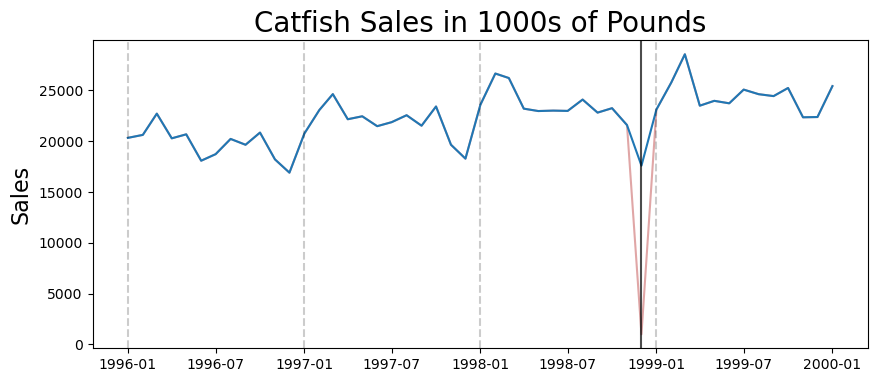

In [45]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales, color='firebrick', alpha=0.4)
plt.plot(adjusted_data)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axvline(curr_anomaly, color='k', alpha=0.7)

## Resulting predictions

In [46]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

test_data = adjusted_data[train_end + timedelta(days=1):test_end]

In [47]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = adjusted_data[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred


C:\Users\ASHU\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\ASHU\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\ASHU\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ASHU\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\ASHU\anaconda3\Lib\site-packages\statsmodels\tsa\

In [53]:
rolling_residuals = test_data - rolling_predictions
test_data.squeeze()

Date
1999-08-01    24618
1999-09-01    24430
1999-10-01    25229
1999-11-01    22344
1999-12-01    22372
2000-01-01    25412
Freq: MS, Name: Total, dtype: int64

In [52]:
rolling_predictions.squeeze()

,Total,1999-08-01 00:00:00,1999-09-01 00:00:00,1999-10-01 00:00:00,1999-11-01 00:00:00,1999-12-01 00:00:00,2000-01-01 00:00:00
Date,,,,,,,
1999-08-01,24618,25822.756561,NaN,NaN,NaN,NaN,NaN
1999-09-01,24430,NaN,23956.475901,NaN,NaN,NaN,NaN
1999-10-01,25229,NaN,NaN,25236.340082,NaN,NaN,NaN
1999-11-01,22344,NaN,NaN,NaN,23378.678223,NaN,NaN
1999-12-01,22372,NaN,NaN,NaN,NaN,20791.333622,NaN
2000-01-01,25412,NaN,NaN,NaN,NaN,NaN,27720.927894


In [61]:
data = {
    'Total': [24618, 24430, 25229, 22344, 22372, 25412],
    '1999-08-01 00:00:00': [25822.756561, np.nan, np.nan, np.nan, np.nan, np.nan],
    '1999-09-01 00:00:00': [np.nan, 23956.475901, np.nan, np.nan, np.nan, np.nan],
    '1999-10-01 00:00:00': [np.nan, np.nan, 25236.340082, np.nan, np.nan, np.nan],
    '1999-11-01 00:00:00': [np.nan, np.nan, np.nan, 23378.678223, np.nan, np.nan],
    '1999-12-01 00:00:00': [np.nan, np.nan, np.nan, np.nan, 20791.333622, np.nan],
    '2000-01-01 00:00:00': [np.nan, np.nan, np.nan, np.nan, np.nan, 27720.927894]
}
index = pd.to_datetime(['1999-08-01', '1999-09-01', '1999-10-01', '1999-11-01', '1999-12-01', '2000-01-01'])
df = pd.DataFrame(data, index=index)

# Extract the 'Total' column and the rest of the data
total_col = df['Total']
non_total_data = df.drop(columns=['Total'])

# Initialize an empty list to store results
residuals_list = []

# Calculate residuals for each row
for date, row in df.iterrows():
    total_value = row['Total']
    # Subtract total_value from non-NaN values
    residuals = row.drop('Total') - total_value
    # Drop NaN values and align the result with the Date
    residuals = residuals.dropna()
    for col_date, residual in residuals.items():
        residuals_list.append({'Date': col_date, 'Residual': residual})

# Create a DataFrame from the list of residuals
aligned_results = pd.DataFrame(residuals_list)

# Convert 'Date' column to datetime format
aligned_results['Date'] = pd.to_datetime(aligned_results['Date'])

# Create a DataFrame with 'Date' and 'Total'
total_df = pd.DataFrame({
    'Date': total_col.index,
    'Total': total_col.values
})

# Merge the residuals with the 'Total' DataFrame based on 'Date'
final_results = pd.merge(total_df, aligned_results, how='left', left_on='Date', right_on='Date')

# Update 'Total' column with the 'Residual' values and drop the 'Residual' column
final_results['Total'] = final_results['Residual']
final_results = final_results.drop(columns=['Residual'])

# Set the 'Date' column as the index
final_results = final_results.set_index('Date')

# Print the result
print(final_results)

                  Total
Date                   
1999-08-01  1204.756561
1999-09-01  -473.524099
1999-10-01     7.340082
1999-11-01  1034.678223
1999-12-01 -1580.666378
2000-01-01  2308.927894


In [62]:
final_results

,Total
Date,
1999-08-01,1204.756561
1999-09-01,-473.524099
1999-10-01,7.340082
1999-11-01,1034.678223
1999-12-01,-1580.666378
2000-01-01,2308.927894


Text(0, 0.5, 'Error')

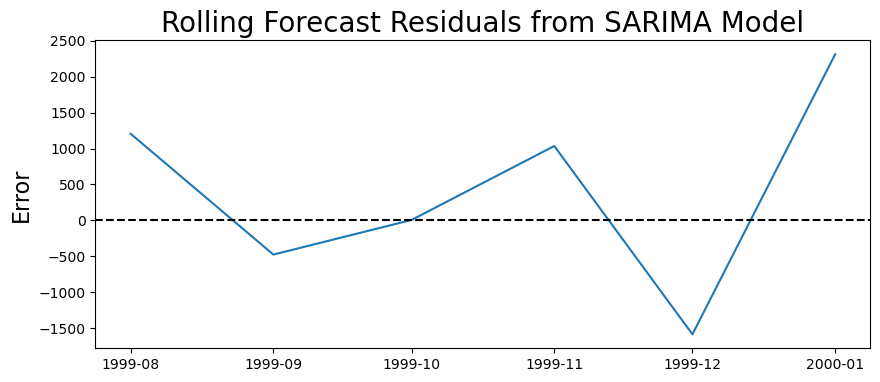

In [63]:
plt.figure(figsize=(10,4))
plt.plot(final_results)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

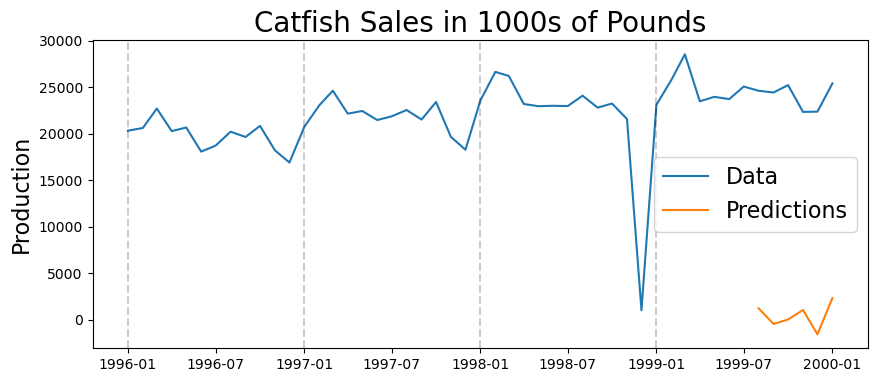

In [65]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(final_results)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## need to see the code again